##### Akeem Wells ( ajw3rg@virginia.edu )
##### DS 5001
##### 10 May 2021

In [1]:
import pandas as pd
import numpy as np
import re 
import os
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import seaborn as sns
from glob import glob
import nltk
from nltk.stem.porter import PorterStemmer
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

sns.set(style="ticks")

%matplotlib inline

In [2]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

In [3]:
def generate_TFIDF( tokens_df, ocho_level, type_count, tf_method, idf_method, tf_norm_k = 0.5):

    """
    #count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
    #tf_method = 'sum' # sum, max, log, double_norm, raw, binary
    #tf_norm_k = .5 # only used for double_norm
    #idf_method = 'standard'
    """
    import numpy as np
    
    print('TF method: {}'.format(tf_method))
    print('IDF method: {}'.format(idf_method))

    tf_methods = ['sum', 'max', 'log', 'double_norm', 'raw', 'binary']
    if tf_method not in tf_methods:
        raise Exception("TF Method must be : {} ".format(', '.join(tf_methods)))
    
    idf_methods = ['standard', 'max', 'smooth']
    if idf_method not in idf_methods:
        raise Exception("IDF Method must be : {} ".format(', '.join(idf_method)))
        
    ### The tokens data frame to use
    TOKEN = tokens_df
    
    ### The OHCO level to use, e.g. which "bag" to use
    bag = ocho_level
    
    ### The type of count to use (e.g. binary counts are regular counts)
    count_method = type_count # 'c' or 'n' # n = n tokens, c = distinct token (term) count
    if count_method not in ['c','n']:
        raise Exception("Count Method must be 'n'(tokens) or 'c' (distinct token (term) count) ")

    ##### Create Count Matrix
    ### Bag of Words
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    ### Document-Term Matrix
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    
    ### The type of TF to use
    #Compute TF
    if tf_method == 'sum': 
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max': 
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log': 
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw': 
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
    elif tf_method == 'binary': 
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T

    
    ### The type of IDF to use
    # Compute DF
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0]
    
    # Compute IDF
    if idf_method == 'standard': 
        IDF = np.log10(N / DF)
    elif idf_method == 'max': 
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth': 
        IDF = np.log10((1 + N) / (1 + DF)) + 1 # Correct?
    

    TFIDF = TF * IDF
    
    return TFIDF, DTCM

In [4]:
OHCO = ["genre", "sent_num"]

In [5]:
TOKENS = pd.read_csv("TOKENS.csv")
LIB = pd.read_csv("LIB.csv")
VOCAB = pd.read_csv("VOCAB.csv").set_index("term_id").sort_index()

In [6]:
TOKEN = pd.merge(LIB,TOKENS, on = ["title"]).set_index(["song_id","sent_num","token_num"])

In [7]:
columns = ['song_file','genre_x','genre_y','song_file',"artist_x","artist_y", "title","year"]
TOKEN.drop(columns, inplace=True, axis=1)

In [8]:
LIB = LIB.set_index("song_id")

In [9]:
VOCAB = VOCAB.dropna()
TOKEN = TOKEN.dropna()

In [10]:
TOKEN.head()

pos_tuple pos token_str term_str  term_id
song_id sent_num token_num                                                   
1001    0        0            ('truth', 'NN')  NN     truth    truth    11236
        1        0           ('redone', 'NN')  NN    redone   redone     8681
        2        0          ('konvict', 'NN')  NN   konvict  konvict     5937
        3        0             ('gaga', 'NN')  NN      gaga     gaga     4349
                 1             ('ohoh', 'NN')  NN      ohoh     ohoh     7439

In [11]:
LIB.head()

,title,artist,year,song_file,genre
song_id,,,,,
1001,justdance,ladygaga,2009,data/2009/pop/Just_Dance---lady_gaga_.txt,pop
1002,mylifewouldsuckwithoutyou,kellyclarkson,2009,data/2009/pop/My_Life_Would_Suck_Without_You--...,pop
1003,idonothookup,kellyclarkson,2009,data/2009/pop/I_Do_Not_Hook_Up---kelly_clarkso...,pop
1004,paparazzi,ladygaga,2009,data/2009/pop/Paparazzi---lady_gaga.txt,pop
1005,wakingupinvegas,katyperry,2009,data/2009/pop/Waking_Up_In_Vegas---katy_perry.txt,pop


In [12]:
VOCAB.head()

,term_rank,term_str,n,num,stop,p_stem,pos_max
term_id,,,,,,,
1,10407,01,1,1,0,01,CD
2,7594,06,1,1,0,06,CD
3,7531,082,1,1,0,082,CD
4,7523,092,1,1,0,092,CD
5,1330,1,15,1,0,1,CD


In [13]:
bag = ["song_id"]

In [14]:
BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')

In [15]:
BOW.head()

n  c
song_id term_id      
1001    176      4  1
        188      1  1
        360      1  1
        394      3  1
        419      1  1

In [16]:
TFIDF,DTCM  = generate_TFIDF(TOKEN, bag, 'n',  'sum','standard' )

TF method: sum
IDF method: standard


In [17]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,12361,12362,12364,12366,12367,12373,12377,12378,12380,12381
song_id,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
DTCM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,12361,12362,12364,12366,12367,12373,12377,12378,12380,12381
song_id,,,,,,,,,,,,,,,,,,,,,
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
VOCAB['tfidf_mean'] = TFIDF[TFIDF > 0].mean().fillna(0) # EXPLAIN
VOCAB['tfidf_sum'] = TFIDF.sum()
VOCAB['tfidf_median'] = TFIDF[TFIDF > 0].median().fillna(0) # EXPLAIN
VOCAB['tfidf_max'] = TFIDF.max()

In [20]:
BOW = BOW.join(VOCAB[['term_str','pos_max']], on='term_id')

# Save 

In [21]:
VOCAB.to_csv('VOCAB2.csv')
TOKEN.to_csv('TOKEN2.csv')
BOW.to_csv('BOW.csv')
DTCM.to_csv('DTCM.csv')
TFIDF.to_csv('TFIDF.csv')

#  Similarity and Distance Measures

In [22]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,12361,12362,12364,12366,12367,12373,12377,12378,12380,12381
song_id,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
OHCO_src = ['song_id']
OHCO = ['song_id']

In [24]:
TFIDF = pd.read_csv( 'TFIDF.csv').set_index(OHCO_src)
VOCAB = pd.read_csv('VOCAB2.csv').set_index('term_id')
LIB = pd.read_csv( 'LIB.csv').set_index('song_id')

In [25]:
TFIDF.head()

,1,2,3,4,5,6,7,8,9,10,...,12361,12362,12364,12366,12367,12373,12377,12378,12380,12381
song_id,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Add Some Labels to the Library

In [26]:
LIB

,title,artist,year,song_file,genre
song_id,,,,,
1001,justdance,ladygaga,2009,data/2009/pop/Just_Dance---lady_gaga_.txt,pop
1002,mylifewouldsuckwithoutyou,kellyclarkson,2009,data/2009/pop/My_Life_Would_Suck_Without_You--...,pop
1003,idonothookup,kellyclarkson,2009,data/2009/pop/I_Do_Not_Hook_Up---kelly_clarkso...,pop
1004,paparazzi,ladygaga,2009,data/2009/pop/Paparazzi---lady_gaga.txt,pop
1005,wakingupinvegas,katyperry,2009,data/2009/pop/Waking_Up_In_Vegas---katy_perry.txt,pop
...,...,...,...,...,...
1877,goodashell,lizzo,2020,data/2020/rap/Good_As_Hell---lizzo.txt,rap
1878,roxanne,arizonazervas,2020,data/2020/rap/Roxanne---arizona_zervas.txt,rap
1879,thewoo,popsmoke,2020,data/2020/rap/The_Woo---pop_smoke_.txt,rap


## Collapse TFIDF

In [27]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [28]:
TFIDF.head()

,1,2,3,4,5,6,7,8,9,10,...,12361,12362,12364,12366,12367,12373,12377,12378,12380,12381
song_id,,,,,,,,,,,,,,,,,,,,,
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a DOC table

In [29]:
DOC = TFIDF.reset_index()[OHCO]

In [30]:
DOC["song_id"] = DOC["song_id"].apply( lambda x: str(x))

In [31]:
DOC.head()

,song_id
0,1001
1,1002
2,1003
3,1004
4,1005


## Add a meaningful Title to DOC index

In [32]:
# DOC['title'] = DOC.book_id.map(LIB.author) \
#    + '-' + DOC[OHCO].apply(lambda x: x.astype('str').str.cat(sep='-'), 1) \
#    + ': '+ DOC.book_id.map(LIB.title)
MYLIB = LIB.reset_index()
MYLIB['song_id'] = MYLIB['song_id'].apply(lambda x : str(x))
MYLIB['title'] = MYLIB['title'].apply(lambda x : str(x))
MYLIB['year'] = MYLIB['year'].apply(lambda x : str(x))

MYLIB = MYLIB.set_index('song_id')

DOC['title'] = DOC.song_id.map(MYLIB.year) + ': '+ DOC.song_id.map(MYLIB.title)

In [33]:
MYLIB.head()

,title,artist,year,song_file,genre
song_id,,,,,
1001,justdance,ladygaga,2009,data/2009/pop/Just_Dance---lady_gaga_.txt,pop
1002,mylifewouldsuckwithoutyou,kellyclarkson,2009,data/2009/pop/My_Life_Would_Suck_Without_You--...,pop
1003,idonothookup,kellyclarkson,2009,data/2009/pop/I_Do_Not_Hook_Up---kelly_clarkso...,pop
1004,paparazzi,ladygaga,2009,data/2009/pop/Paparazzi---lady_gaga.txt,pop
1005,wakingupinvegas,katyperry,2009,data/2009/pop/Waking_Up_In_Vegas---katy_perry.txt,pop


In [34]:
DOC.head()

,song_id,title
0,1001,2009: justdance
1,1002,2009: mylifewouldsuckwithoutyou
2,1003,2009: idonothookup
3,1004,2009: paparazzi
4,1005,2009: wakingupinvegas


## Create Normalized Tables

In [35]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [36]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [37]:
PAIRS.shape

(387640, 0)

In [38]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

# Compute Distances

In [39]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

# ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
# ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
# ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
# ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard') # Fast, and similar to js
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')
PAIRS['euclidean2'] = pdist(L2, 'euclidean')

### Add one new distance measure for the pdist() function to the ones already in the notebook.

In [40]:
PAIRS['sqeuclidean'] = pdist(TFIDF, 'sqeuclidean')
PAIRS['sqeuclidean2'] = pdist(L2, 'sqeuclidean')
PAIRS['yule'] = pdist(L0, 'yule')
PAIRS['kulsinski'] = pdist(L0, 'kulsinski')

In [41]:
PAIRS.head()

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
0     1       1.390026   0.135941  0.972721  0.851528  0.741445  0.793214   
      2       1.323324   0.112414  0.955343  0.814961  0.687708  0.783132   
      3       1.583042   0.130097  0.937213  0.864865  0.761905  0.797874   
      4       1.457101   0.130509  0.960799  0.843621  0.729537  0.788744   
      5       1.390958   0.130466  0.974010  0.836910  0.719557  0.796247   

             euclidean2  sqeuclidean  sqeuclidean2      yule  kulsinski  
doc_a doc_b                                                              
0     1        1.394791     0.018480      1.945443  0.034613   0.997287  
      2        1.382276     0.012637      1.910686  0.034268   0.996253  
      3        1.369097     0.016925      1.874427  0.053057   0.997214  
      4        1.386217     0.017033      1.921598  0.038515   0.996970  
      5        1.395715     0.017021      1.948020  0.032569   0.996968

## Compare Distributions

In [42]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

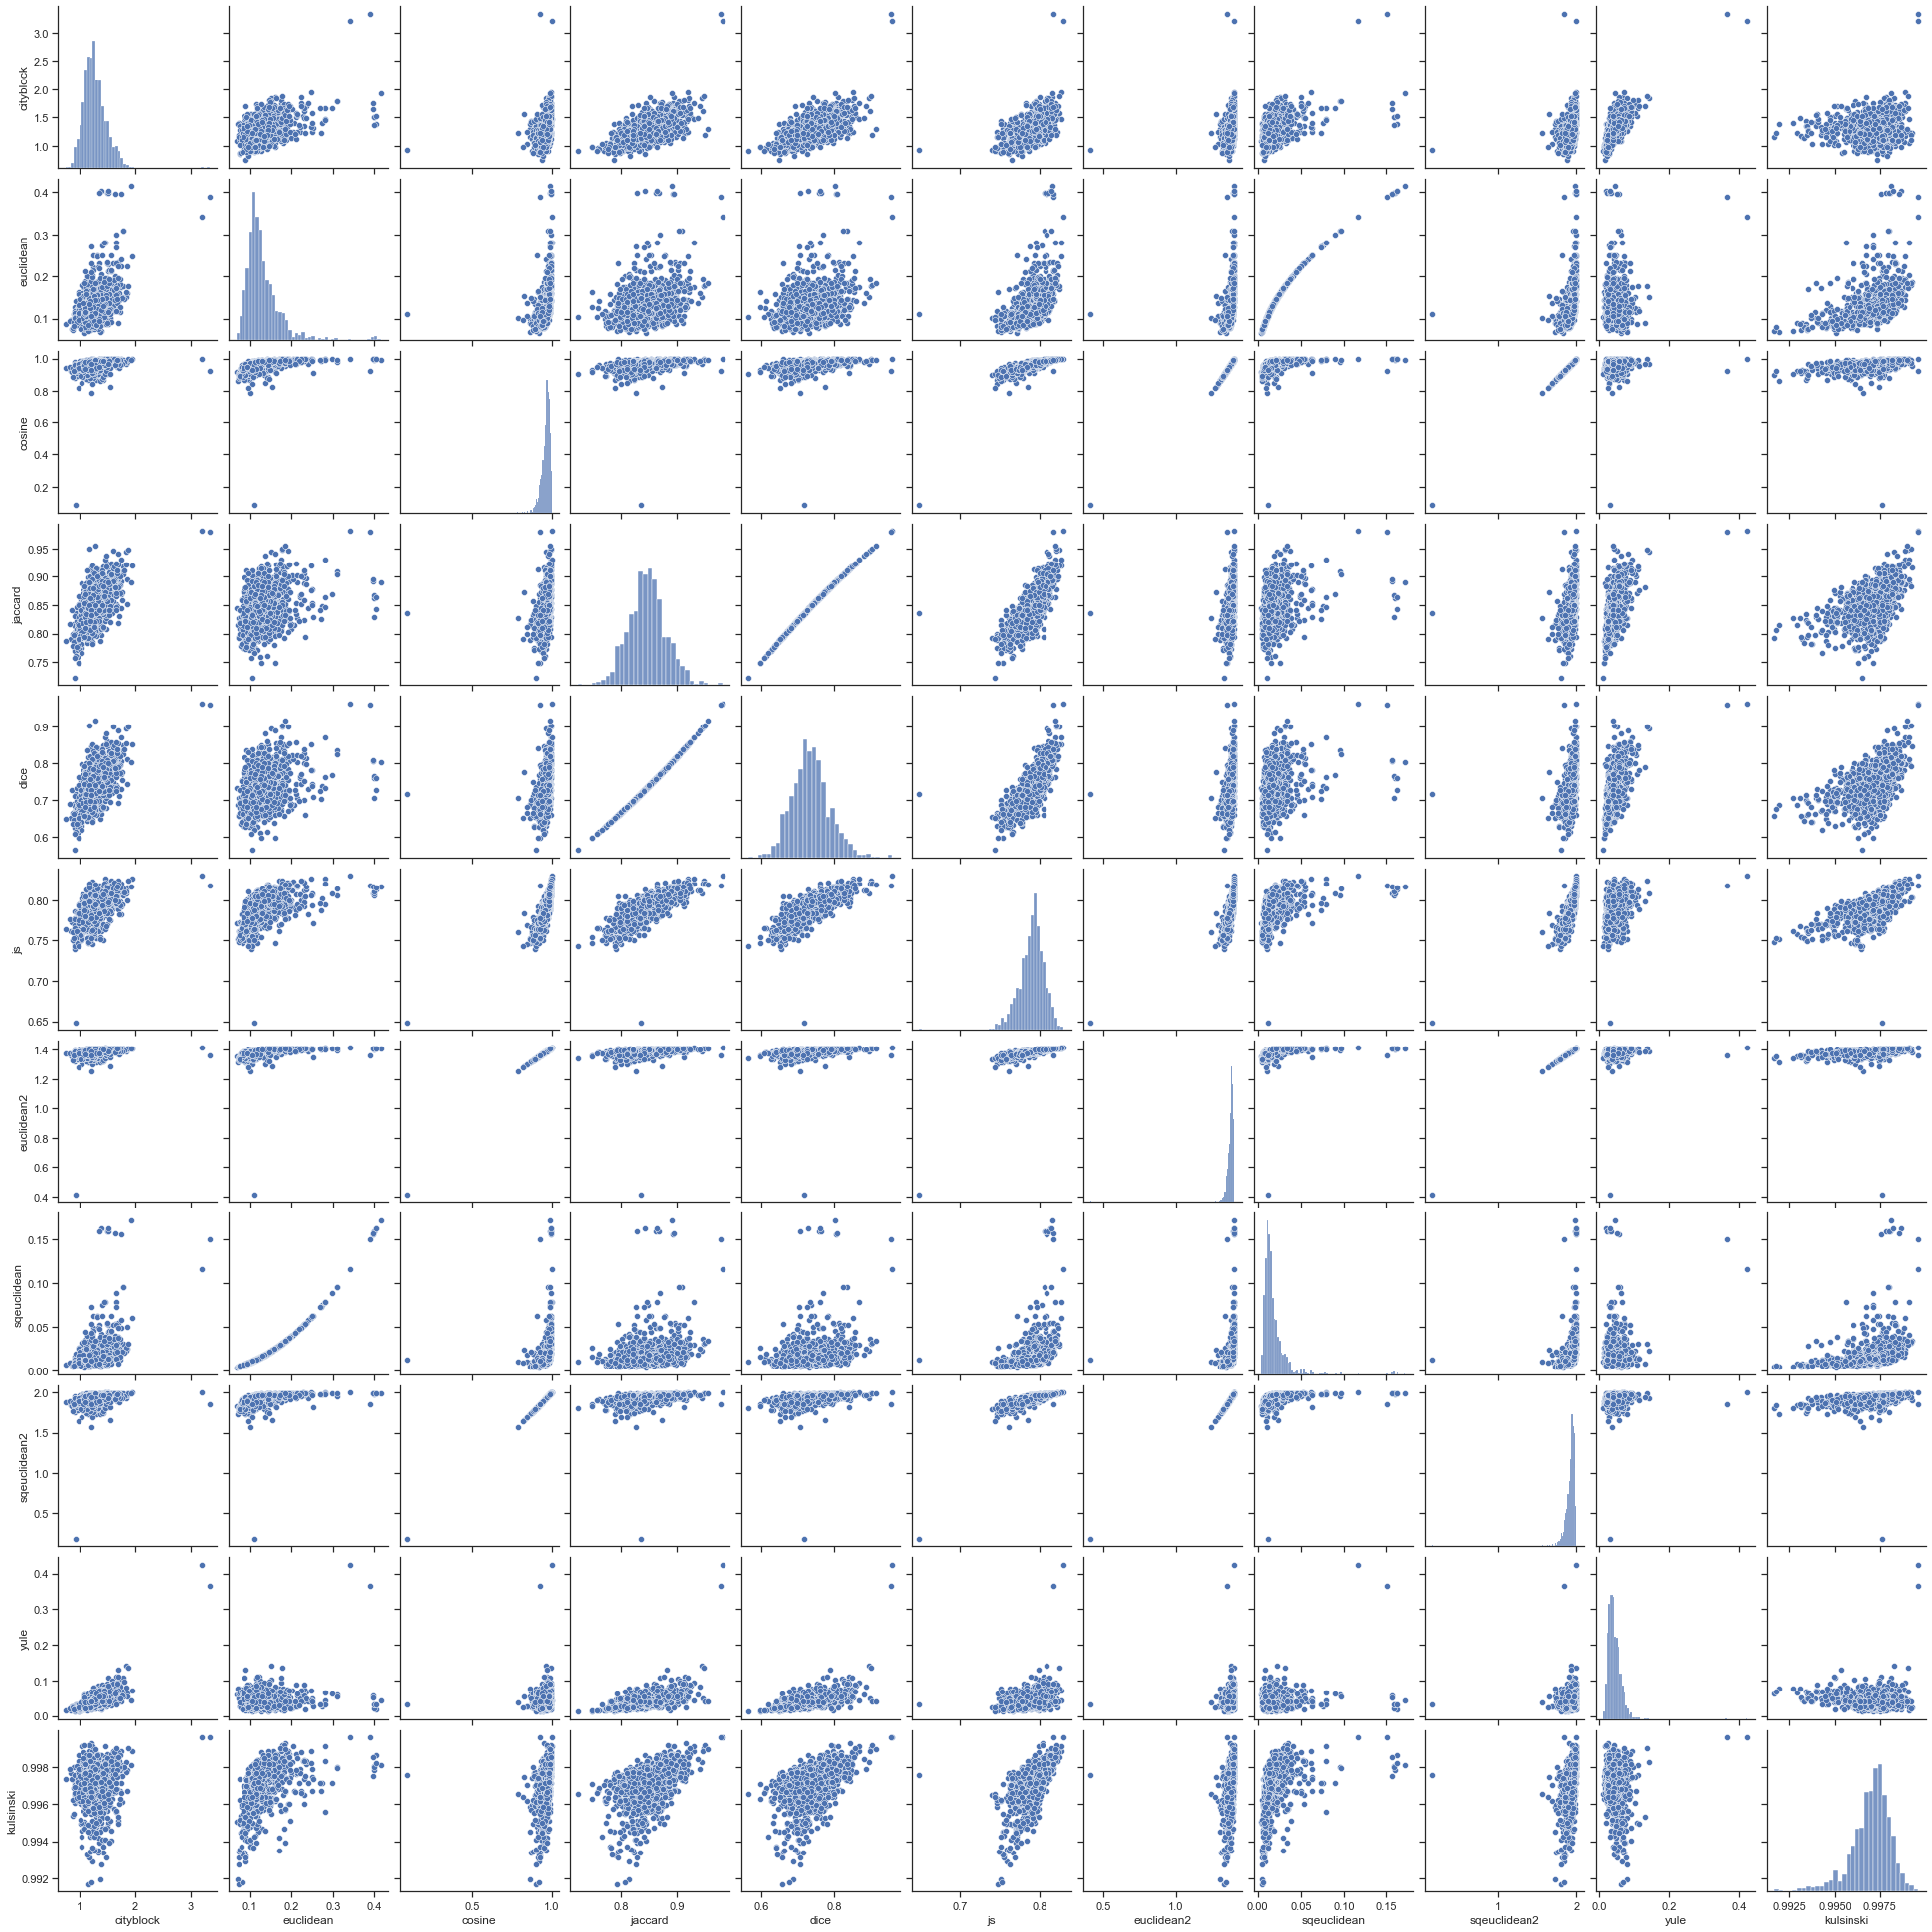

In [43]:
sns.pairplot(SAMPLE)

In [44]:
PAIRS.sort_values('cosine').head(20).style.background_gradient('YlGn')

,,cityblock,euclidean,cosine,jaccard,dice,js,euclidean2,sqeuclidean,sqeuclidean2,yule,kulsinski
doc_a,doc_b,,,,,,,,,,,
611,681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994164
585,694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988409
642,715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.976656
251,334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.983626
416,487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.991084
650,879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971225
235,732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.983626
98,781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.973008
23,333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.982411


# Create Clusters

## Hiearchical

<Figure size 432x288 with 0 Axes>

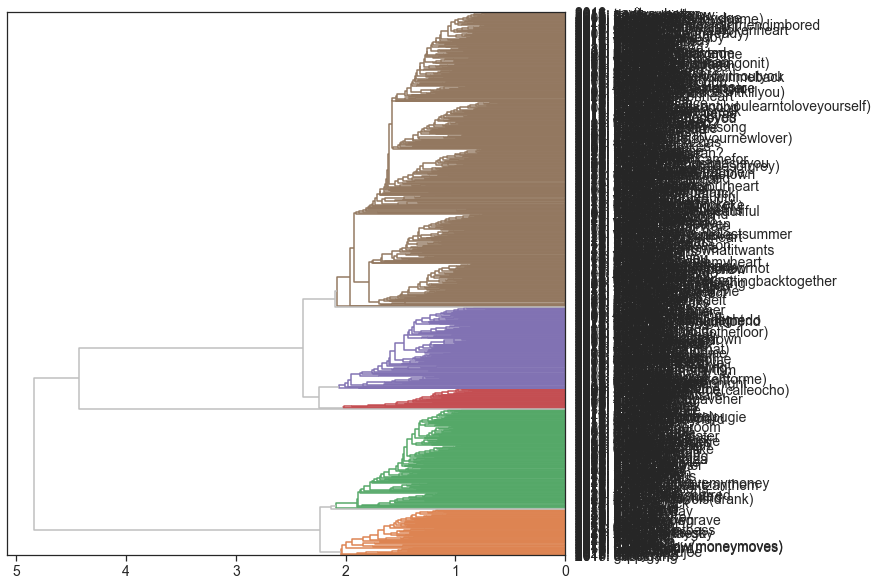

In [45]:
hca(PAIRS.cityblock, color_thresh=2.1)

<Figure size 432x288 with 0 Axes>

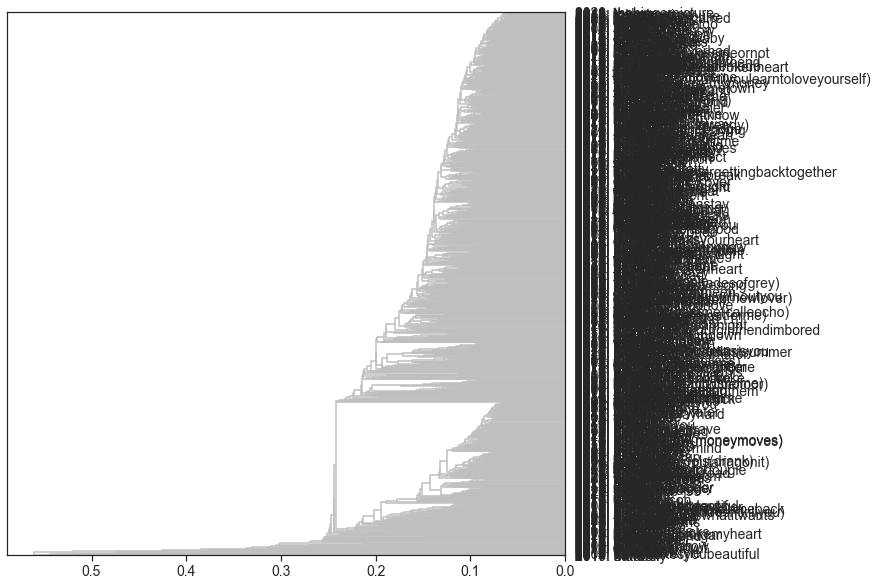

In [46]:
hca(PAIRS.euclidean, color_thresh=.007)

<Figure size 432x288 with 0 Axes>

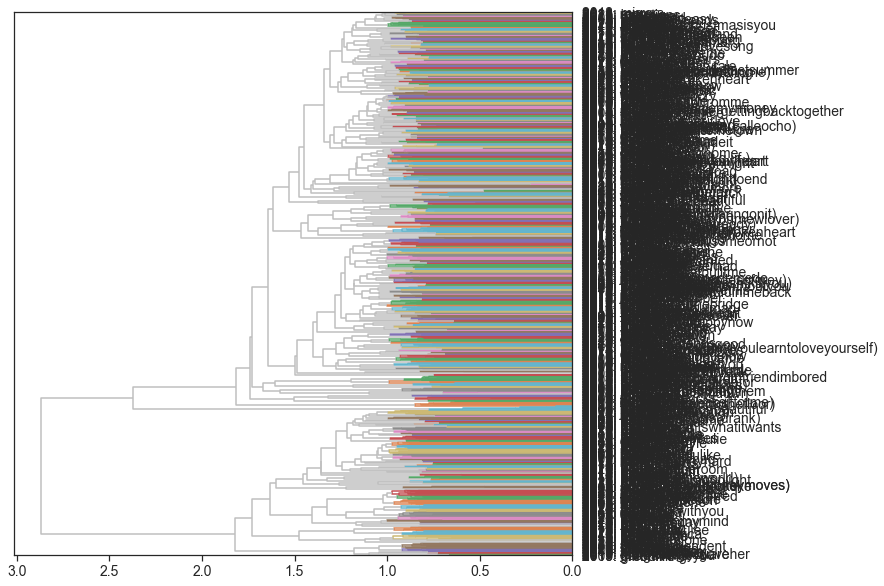

In [47]:
hca(PAIRS.cosine, color_thresh=1.0)

<Figure size 432x288 with 0 Axes>

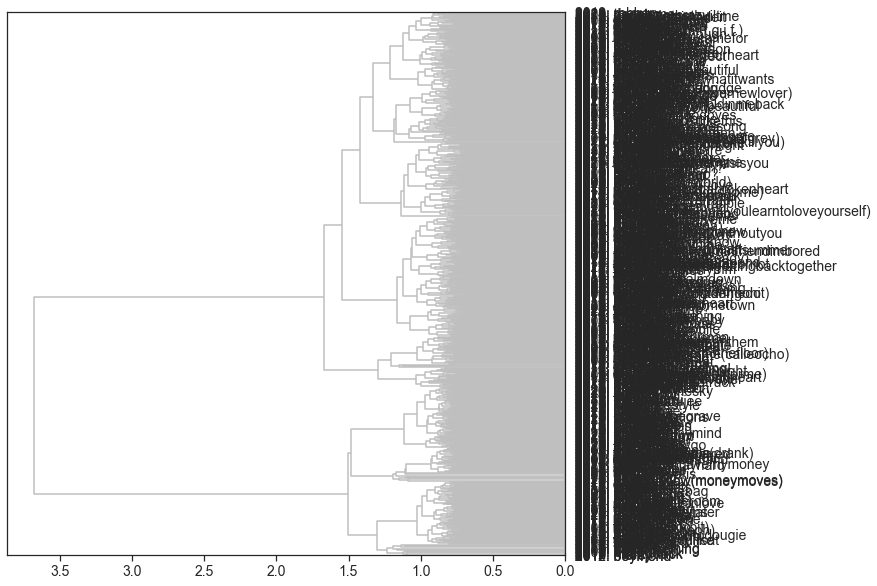

In [48]:
hca(PAIRS.jaccard, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

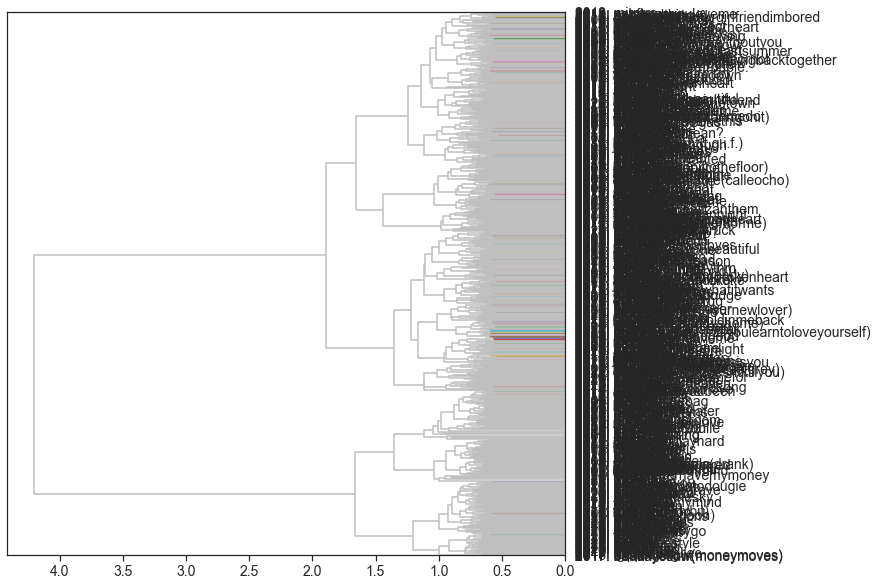

In [49]:
hca(PAIRS.dice, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

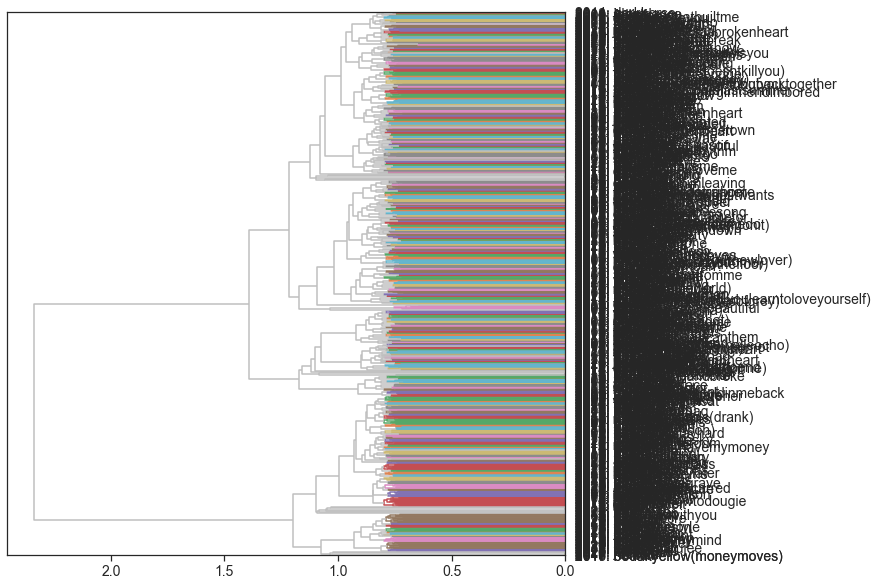

In [50]:
hca(PAIRS.js, color_thresh=.8)

<Figure size 432x288 with 0 Axes>

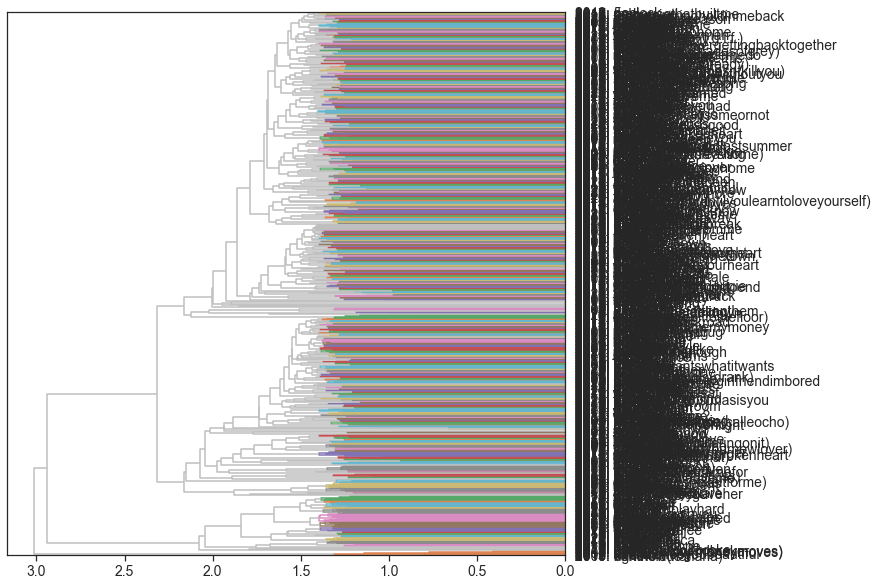

In [51]:
hca(PAIRS.euclidean2, color_thresh=1.4)

<Figure size 432x288 with 0 Axes>

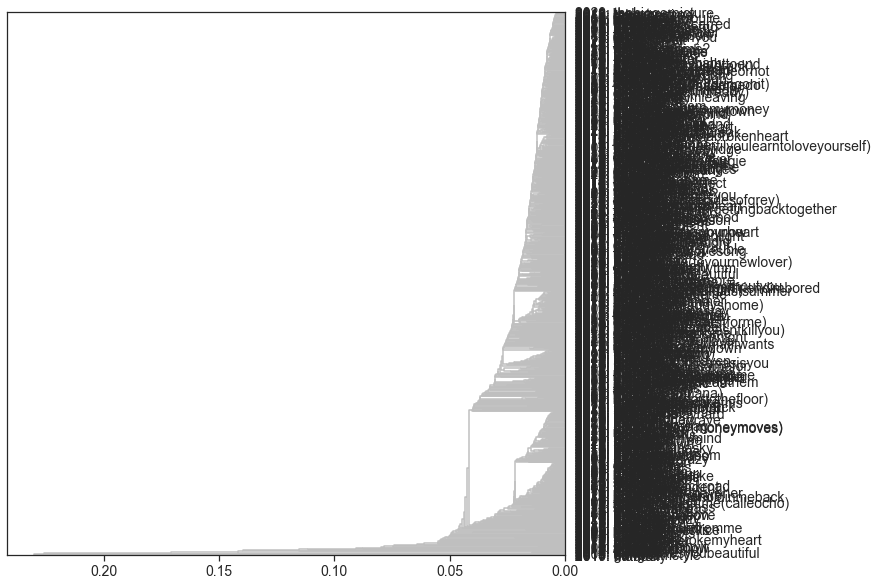

In [52]:
hca(PAIRS.sqeuclidean, color_thresh=.00006)

<Figure size 432x288 with 0 Axes>

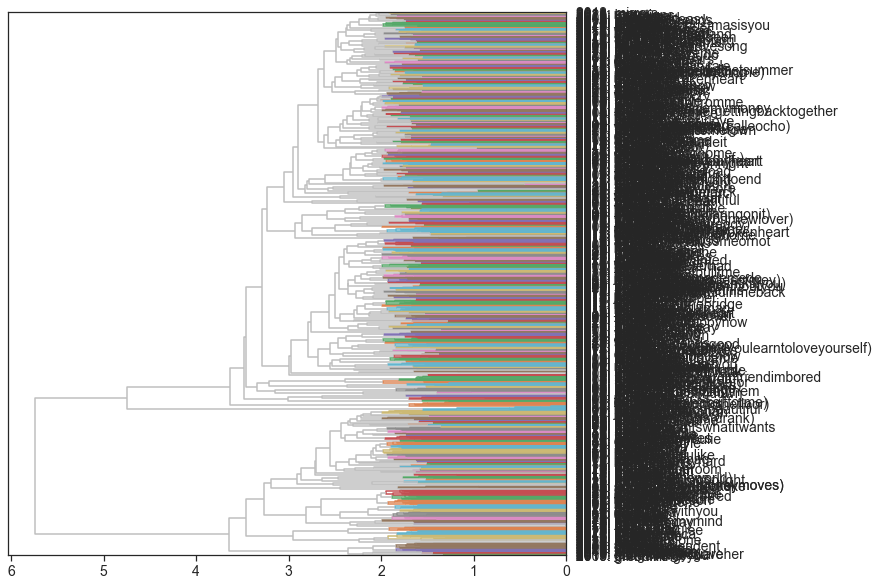

In [53]:
hca(PAIRS.sqeuclidean2, color_thresh=2.0)

<Figure size 432x288 with 0 Axes>

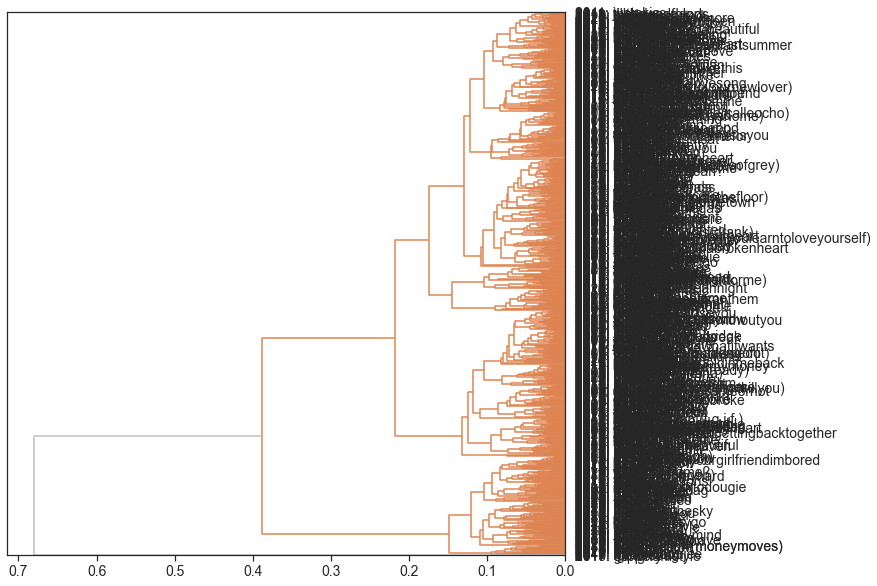

In [54]:
hca(PAIRS.yule, color_thresh=.6)

<Figure size 432x288 with 0 Axes>

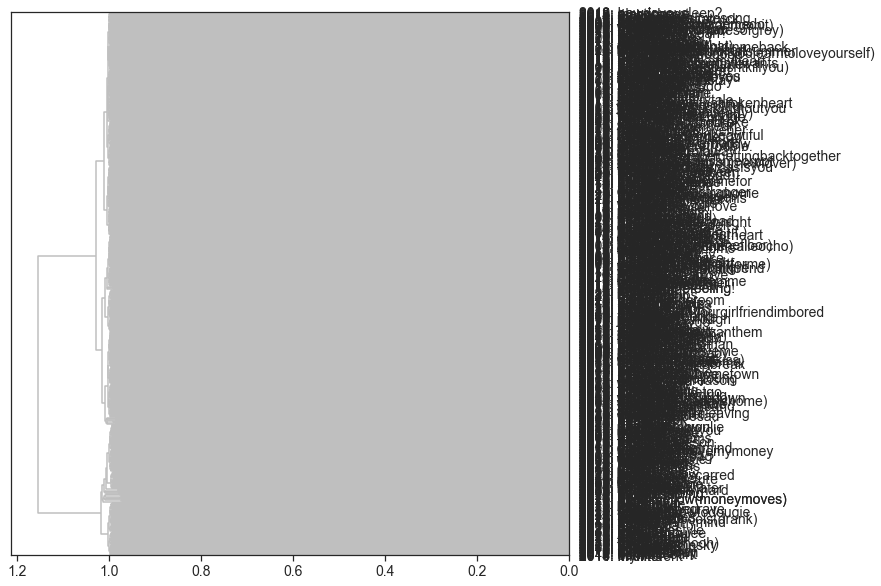

In [55]:
hca(PAIRS.kulsinski, color_thresh=.9)

In [56]:
PAIRS

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
0     1       1.390026   0.135941  0.972721  0.851528  0.741445  0.793214   
      2       1.323324   0.112414  0.955343  0.814961  0.687708  0.783132   
      3       1.583042   0.130097  0.937213  0.864865  0.761905  0.797874   
      4       1.457101   0.130509  0.960799  0.843621  0.729537  0.788744   
      5       1.390958   0.130466  0.974010  0.836910  0.719557  0.796247   
...                ...        ...       ...       ...       ...       ...   
877   879     1.389392   0.140744  0.924755  0.849642  0.738589  0.770584   
      880     1.521712   0.163789  0.956355  0.826772  0.704698  0.780736   
878   879     1.189707   0.081422  0.803005  0.814978  0.687732  0.740284   
      880     1.359321   0.120276  0.944068  0.816054  0.689266  0.773001   
879   880     1.427269   0.110483  0.893823  0.843956  0.730038  0.766425   

             euclidean2  sqeuclidean  sqeuclidean2      yule  kulsinski  
doc_a doc_b                                                              
0     1        1.394791     0.018480      1.945443  0.034613   0.997287  
      2        1.382276     0.012637      1.910686  0.034268   0.996253  
      3        1.369097     0.016925      1.874427  0.053057   0.997214  
      4        1.386217     0.017033      1.921598  0.038515   0.996970  
      5        1.395715     0.017021      1.948020  0.032569   0.996968  
...                 ...          ...           ...       ...        ...  
877   879      1.359967     0.019809      1.849510  0.048570   0.995037  
      880      1.383008     0.026827      1.912710  0.038883   0.996493  
878   879      1.267285     0.006630      1.606011  0.052349   0.993389  
      880      1.374095     0.014466      1.888136  0.043868   0.995628  
879   880      1.337029     0.012206      1.787645  0.065136   0.994419  

[387640 rows x 11 columns]